<a href="https://colab.research.google.com/github/luizgodoy26/mvp_data_analysis/blob/main/C%C3%B3pia_de_Predi%C3%A7%C3%A3o_de_prefer%C3%AAncia_liter%C3%A1ria_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Análise de Dados e Boas Práticas

**Nome:** Luiz Daniel de Godoy Nunes

**Matrícula:** XX

**Datasets:** [Book Ratings](https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset?resource=download) e [Best Book Ever](https://www.kaggle.com/datasets/arnabchaki/goodreads-best-books-ever)


# Descrição do Problema
Origem das bases: [Book Ratings](https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset?resource=download) e [Best Book Ever](https://www.kaggle.com/datasets/arnabchaki/goodreads-best-books-ever)

O objetivo deste projeto é prever a probabilidade de um usuário gostar de um determinado livro com base em seu histórico de avaliações e nas características do livro em questão. Para isso, utilizamos dois conjuntos de dados relacionados ao universo literário:


*   BX-Book-Ratings.csv: contém registros de avaliações atribuídas por usuários a livros, identificados por seus respectivos IDs.
*   books_1.Best_Books_Ever.csv: apresenta informações detalhadas sobre os livros, incluindo título, autor, gênero, número de páginas e avaliação média.


A tarefa consiste em construir um modelo que, a partir da entrada do ID de um usuário e do ID de um livro, consiga estimar a probabilidade de o usuário gostar deste livro. Para isso, serão consideradas variáveis como:


1. Quais livros o usuário já leu;
2. Quais os gêneros literários mais presentes no histórico de leitura do usuário;
3. A média das avaliações que o usuário deu para livros do mesmo gênero;
4. O número de páginas do livro sugerido em comparação com os livros lidos;
5. O autor do livro e o padrão de avaliações para livros deste autor;
6. A avaliação média geral do livro sugerido.

O problema pode ser tratado como uma tarefa de classificação binária ou de regressão, dependendo da estratégia adotada (por exemplo, prever uma nota diretamente ou prever a probabilidade de uma nota alta).


## Seleção de Dados

Para esta análise, foram utilizados dois conjuntos de dados disponíveis publicamente no Kaggle:

BX-Book-Ratings.csv: contém avaliações de usuários para diferentes livros, identificados por ISBN, juntamente com o ID do usuário e a nota atribuída.

books_1.Best_Books_Ever.csv: fornece informações detalhadas sobre os livros, como título, autor, número de páginas, gênero e avaliação média geral.

A escolha desses datasets se deve à sua complementaridade: enquanto o primeiro fornece o comportamento do usuário, o segundo permite extrair características do livro que influenciam suas preferências. Antes da modelagem, será necessário realizar um processo de limpeza, padronização de chaves (como ISBNs) e cruzamento entre os dois conjuntos, além da extração de atributos relevantes para a predição

#Checklist

### Tipo de aprendizado
Trata-se de um problema de Aprendizado Supervisionado, uma vez que temos um conjunto de entradas (*features*) como gênero, faixa de páginas, autor, etc. O também modelo é treinado com pares entrada–saída para aprender a prever a nota que um usuário daria a um livro que ainda não leu.

### Premissas e hipóteses
- Preferência do usuário é consistente: se um usuário gostou de um autor ou gênero no passado, há alta probabilidade de gostar novamente.
- A faixa de páginas influencia a preferência: leitores podem ter preferência por livros curtos ou longos.
- A média geral (*average_rating*) do livro é uma medida aproximada da aceitação global, mas menos personalizada.
- Histórico do usuário é suficiente para prever comportamento futuro.
- A combinação de múltiplos fatores melhora a predição do gosto do usuário

### Restrições e condições
- Apenas usuários que já avaliaram livros são considerados (*sem cold start*).
- A entrada exige um user_id e um isbn para prever uma nota ou verificar se o livro já foi avaliado.
- A predição se baseia apenas em informações derivadas do próprio usuário, não em dados de outros usuários (modelo centrado no usuário, não colaborativo). Ainda que o *average_rating* seja uma amostragem da avaliação de outros usuários.
- A faixa de páginas foi discretizada em categorias, não é contínua.

### Atributos do dataset.

| Atributo         | Tipo          | Descrição                                                                        |
| ---------------- | ------------- | -------------------------------------------------------------------------------- |
| `user_id`        | Numérico      | Identificador único de um usuário.                                               |
| `isbn`           | Texto         | Identificador único do livro (código ISBN).                                      |
| `user_rating`    | Numérico      | Nota que o usuário deu ao livro (alvo do modelo).                                |
| `average_rating` | Numérico      | Nota média do livro considerando todos os usuários.                              |
| `Title`          | Texto         | Título do livro.                                                                 |
| `Author`         | Texto         | Nome(s) do(s) autor(es) do livro.                                                |
| `num_pages`      | Numérico      | Número total de páginas do livro.                                                |
| `genres`         | Texto → Lista | Lista de gêneros atribuídos ao livro. Ex: `['Fantasy', 'Adventure']`.            |
| `faixa_paginas`  | Categórico    | Faixa de número de páginas, categorizada como `(0, 100]`, `(200, 300]` etc.      |
| `media_autor`    | Numérico      | Média de notas que o usuário deu a livros do mesmo autor. (gerado)               |
| `media_genero`   | Numérico      | Média de notas que o usuário deu a livros com gêneros semelhantes. (gerado)      |
| `media_paginas`  | Numérico      | Média de notas que o usuário deu a livros com a mesma faixa de páginas. (gerado) |


# Importação das Bibliotecas Necessárias e Carga de Dados


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# paleta de cores
cores = {
    'azul':    '#66CCFF',
    'roxo':    '#7A66FF',
    'rosa':    '#F766FF',
    'salmao':  '#FF7866',
    'amarelo': '#FFBA66',
    'verde':   '#66FF8F'
}


In [2]:
# caminhos dos arquivos do drive
ratings_path = 'https://raw.githubusercontent.com/luizgodoy26/mvp_data_analysis/refs/heads/main/BX-Book-Ratings.csv'
books_path = 'https://raw.githubusercontent.com/luizgodoy26/mvp_data_analysis/refs/heads/main/Goodreads_books_with_genres.csv'

# salver os arquivos em dataframes
ratings = pd.read_csv(ratings_path, sep=';', encoding='latin1')
books = pd.read_csv(books_path, encoding='latin1')

# Tratamento inicial dos dados

In [3]:
# renomeio colunas
ratings.columns = ['user_id', 'isbn', 'user_rating']
ratings = ratings.dropna(subset=['user_id', 'isbn', 'user_rating'])
ratings['isbn'] = ratings['isbn'].astype(str)


# removo nulos e vazios da tabela de livros
books = books.dropna(subset=['isbn', 'genres', 'num_pages', 'Author', 'average_rating'])
books['isbn'] = books['isbn'].astype(str)

# mantendo ibn como string para melhor compatibilidade
books = books.dropna(subset=['isbn', 'genres', 'num_pages', 'Author', 'average_rating'])
books['isbn'] = books['isbn'].astype(str)


# consider0 somente avaliações válidas
ratings = ratings[ratings['user_rating'] > 0]


# a base de livros possui uma escala 1-5 e a de avaliações possui escala 1-10, normalizo a escala dessa forma
ratings['user_rating'] = ratings['user_rating'] / 2


# considero somente livros com mais de 30 paginas
books = books[books['num_pages'] > 30]


# unifico os 2 datasets
merged = ratings.merge(books, on='isbn')
merged = merged[['user_id', 'isbn', 'user_rating', 'average_rating', 'Title', 'Author', 'num_pages', 'genres']]

/tmp/ipython-input-3-745063998.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books['isbn'] = books['isbn'].astype(str)
/tmp/ipython-input-3-745063998.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['user_rating'] = ratings['user_rating'] / 2


In [4]:
# garanto que generos estão como listas
merged['genres'] = merged['genres'].apply(lambda x: [g.strip() for g in x.split(';')] if isinstance(x, str) else [])

# calculo a média de notas por gnero similar
def calcular_media_genero(row):
    user_books = merged[merged['user_id'] == row['user_id']]
    similares = user_books[user_books['genres'].apply(lambda g: len(set(g) & set(row['genres'])) > 0)]
    if not similares.empty:
        return similares['user_rating'].mean()
    return None

# crio uma faixa por pgs
merged['faixa_paginas'] = pd.cut(merged['num_pages'], bins=[0, 100, 200, 300, 400, 600, 800, 1000, 1500, 2000])

# calculo as médias auxiliares
merged['media_autor'] = merged.groupby(['user_id', 'Author'])['user_rating'].transform('mean')
merged['media_paginas'] = merged.groupby(['user_id', 'faixa_paginas'])['user_rating'].transform('mean')
merged['media_genero'] = merged.apply(calcular_media_genero, axis=1)


/tmp/ipython-input-4-2210765069.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged['media_paginas'] = merged.groupby(['user_id', 'faixa_paginas'])['user_rating'].transform('mean')


In [5]:
print(f"Tabela unificada: {merged.shape[0]}")
merged.head()

Tabela unificada: 22975


,user_id,isbn,user_rating,average_rating,Title,Author,num_pages,genres,faixa_paginas,media_autor,media_paginas,media_genero
0,276747,0679776818,4.0,4.09,Birdsong,Sebastian Faulks,483,"[Historical,Historical Fiction, Fiction, War, ...","(400, 600]",4.0,4.0,4.0
1,276798,3548603203,3.0,3.84,Artemis Fowl (Artemis Fowl #1),Eoin Colfer/Claudia Feldmann,240,"[Fantasy, Young Adult, Fiction, Childrens,Midd...","(200, 300]",3.0,3.0,3.0
2,276808,0395547032,5.0,4.25,A Confederate General from Big Sur / Dreaming ...,Richard Brautigan,608,"[Fiction, Literature, Poetry, Literary Fiction...","(600, 800]",5.0,5.0,5.0
3,276822,0439401399,3.0,3.85,The Contest (Everest #1),Gordon Korman,96,"[Adventure, Young Adult, Fiction, Realistic Fi...","(0, 100]",3.0,3.0,3.0
4,276872,0425188221,3.5,3.91,Shadowland,Peter Straub,468,"[Horror, Fantasy, Fiction, Thriller, Fantasy,M...","(400, 600]",3.5,3.5,3.5


In [6]:
# descrever a tabela
merged.describe()

,user_id,user_rating,average_rating,num_pages,media_autor,media_paginas,media_genero
count,22975.000000,22975.000000,22975.000000,22975.000000,22975.000000,22975.000000,22975.000000
mean,137000.922481,3.896322,3.910421,382.466855,3.896322,3.896322,3.896321
std,80943.062497,0.877175,0.241142,166.829207,0.870106,0.785689,0.720595
min,39.000000,0.500000,2.770000,32.000000,0.500000,0.500000,0.500000
25%,68058.500000,3.500000,3.770000,288.000000,3.500000,3.500000,3.500000
50%,135149.000000,4.000000,3.920000,356.000000,4.000000,4.000000,4.000000
75%,208058.500000,4.500000,4.060000,451.000000,4.500000,4.500000,4.500000
max,278854.000000,5.000000,4.760000,1838.000000,5.000000,5.000000,5.000000


# Análise exploratória

In [7]:
# dimensões do df
print(f"Número de instâncias: {merged.shape[0]}")
print(f"Número de atributos: {merged.shape[1]}")

# tipos de dados
print("\nTipos de dados por coluna:")
print(merged.dtypes)

# 5 primeiras linhas
print("\nPrimeiras 5 linhas do dataset:")
display(merged.head())


Número de instâncias: 22975
Número de atributos: 12

Tipos de dados por coluna:
user_id              int64
isbn                object
user_rating        float64
average_rating     float64
Title               object
Author              object
num_pages            int64
genres              object
faixa_paginas     category
media_autor        float64
media_paginas      float64
media_genero       float64
dtype: object

Primeiras 5 linhas do dataset:


,user_id,isbn,user_rating,average_rating,Title,Author,num_pages,genres,faixa_paginas,media_autor,media_paginas,media_genero
0,276747,0679776818,4.0,4.09,Birdsong,Sebastian Faulks,483,"[Historical,Historical Fiction, Fiction, War, ...","(400, 600]",4.0,4.0,4.0
1,276798,3548603203,3.0,3.84,Artemis Fowl (Artemis Fowl #1),Eoin Colfer/Claudia Feldmann,240,"[Fantasy, Young Adult, Fiction, Childrens,Midd...","(200, 300]",3.0,3.0,3.0
2,276808,0395547032,5.0,4.25,A Confederate General from Big Sur / Dreaming ...,Richard Brautigan,608,"[Fiction, Literature, Poetry, Literary Fiction...","(600, 800]",5.0,5.0,5.0
3,276822,0439401399,3.0,3.85,The Contest (Everest #1),Gordon Korman,96,"[Adventure, Young Adult, Fiction, Realistic Fi...","(0, 100]",3.0,3.0,3.0
4,276872,0425188221,3.5,3.91,Shadowland,Peter Straub,468,"[Horror, Fantasy, Fiction, Thriller, Fantasy,M...","(400, 600]",3.5,3.5,3.5


In [8]:
# verificar valores ausentes
print("\nValores ausentes por coluna:")
print(merged.isnull().sum());


Valores ausentes por coluna:
user_id           0
isbn              0
user_rating       0
average_rating    0
Title             0
Author            0
num_pages         0
genres            0
faixa_paginas     0
media_autor       0
media_paginas     0
media_genero      0
dtype: int64


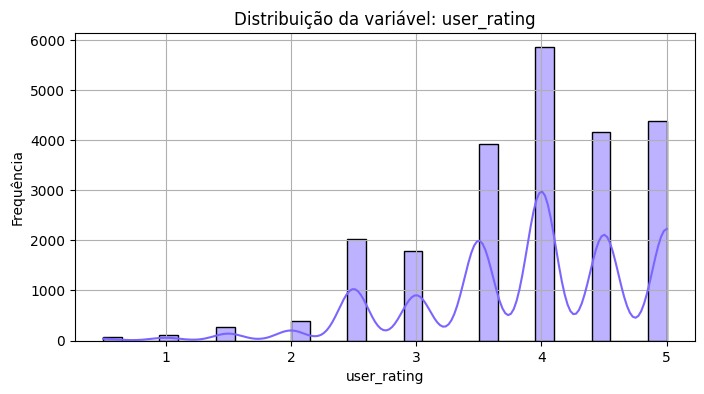

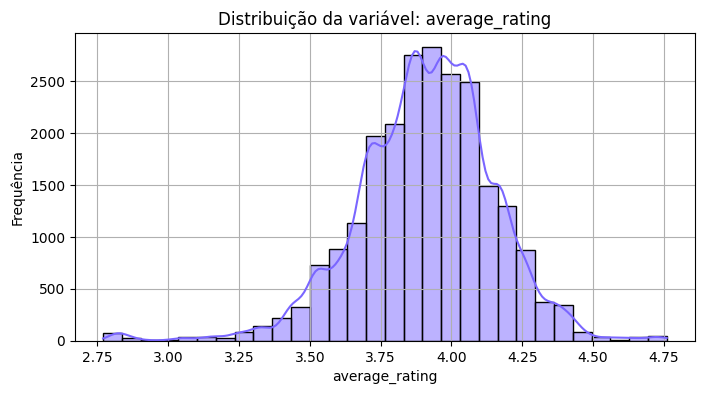

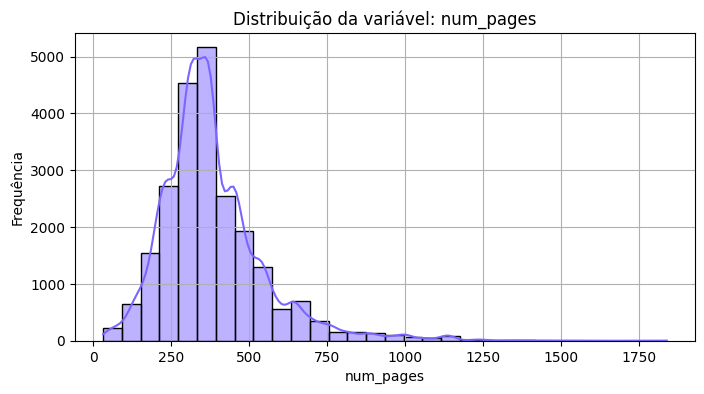

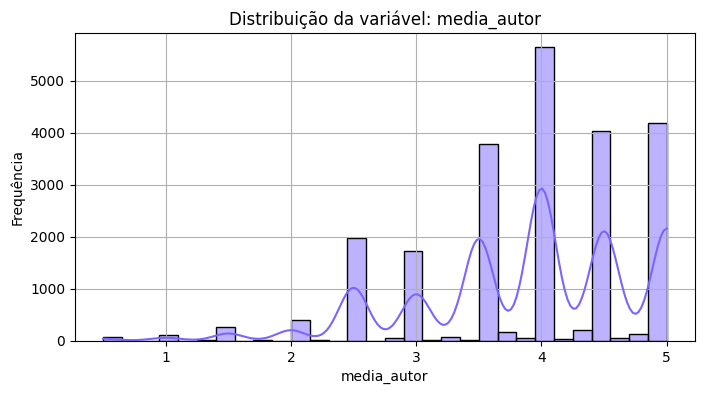

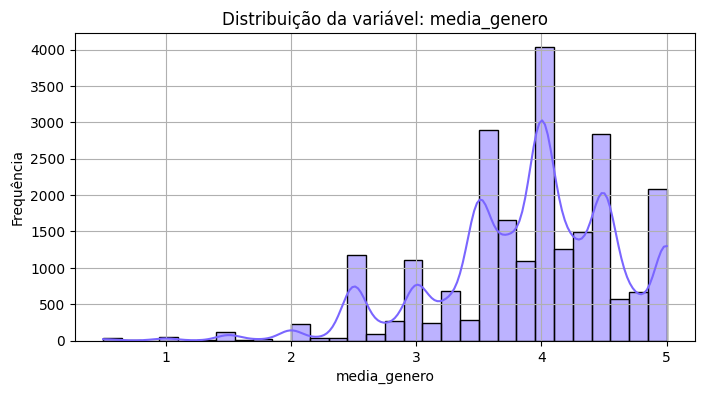

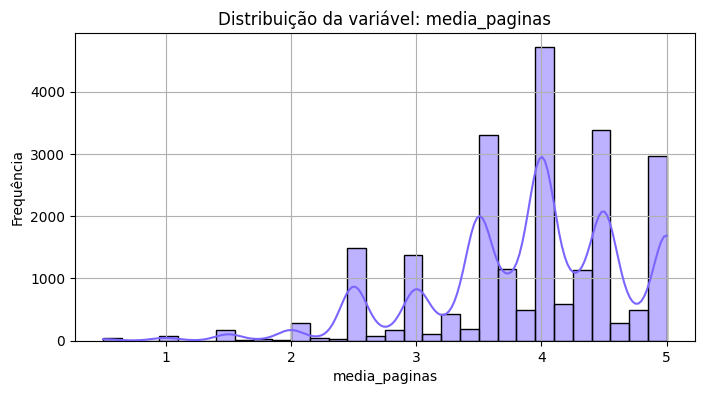

In [9]:
cols_ae = ['user_rating', 'average_rating', 'num_pages', 'media_autor', 'media_genero', 'media_paginas']

for col in cols_ae:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=merged, x=col, kde=True, bins=30, color=cores['roxo'])
    plt.title(f'Distribuição da variável: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.grid(True)
    plt.show()


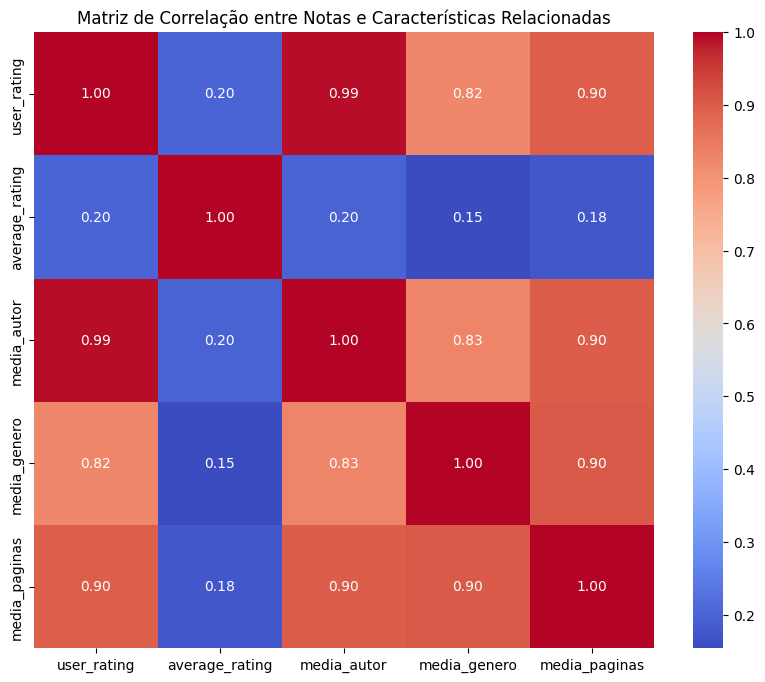

In [10]:

# seleciono as colunas específicas para análise de correlação
cols_cr = merged[['user_rating', 'average_rating', 'media_autor', 'media_genero', 'media_paginas']].dropna()

# Matriz
plt.figure(figsize=(10, 8))
sns.heatmap(cols_cr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação entre Notas e Características Relacionadas')
plt.show()


A análise inicial permite constatar que:
- A maioria dos usuários dá notas entre 4 e 5, com picos claros nesses valores.
- Existe uma distribuição quase normal (*gaussiana*), com pico por volta de 3.9 para o *average_rating*.
- Distribuição com assimetria à direita (*distribuição enviesada*) para o númerode páginas.
- Quando olhamos a nota médio do usuário x autor a distribuição é quase idêntica à de user_rating — forte evidência de consistência do usuário com autores.
-



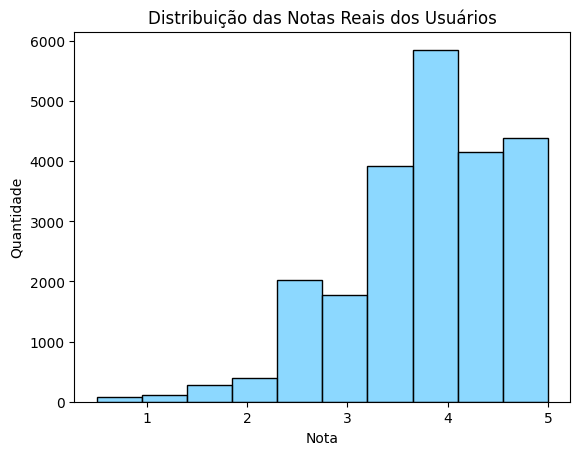

In [11]:
# distribuição das notas dadas pelos usuários
plt.figure()
sns.histplot(merged['user_rating'], bins=10, kde=False, color=cores['azul'])

plt.title('Distribuição das Notas Reais dos Usuários')
plt.xlabel('Nota')
plt.ylabel('Quantidade')
plt.show()


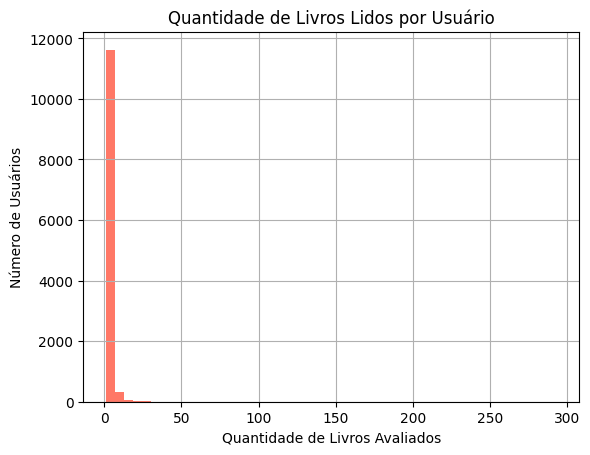

In [12]:
# qtd de livros lidos pelos usuários
books_per_user = merged.groupby('user_id')['isbn'].count().sort_values(ascending=False)
plt.figure()
books_per_user.hist(bins=50, color=cores['salmao'])
plt.title('Quantidade de Livros Lidos por Usuário')
plt.xlabel('Quantidade de Livros Avaliados')
plt.ylabel('Número de Usuários')
plt.show()

Existe uma concentração muito alta de usuários que realizaram menos de 50  leituras, por isso irei filtrar este indicador para não gerar anomalias


In [13]:
# qtd de livros avaliados pelos usuarios
user_counts = merged['user_id'].value_counts()

# vou manter apenas usuários com entre 2 e 50 livros avaliados
valid_users = user_counts[(user_counts >= 2) & (user_counts <= 50)].index
filtered_merged = merged[merged['user_id'].isin(valid_users)]

print(f"Número de registros após filtro por usuários ativos: {filtered_merged.shape[0]}")
print(f"Usuários considerados: {filtered_merged['user_id'].nunique()}")


Número de registros após filtro por usuários ativos: 13916
Usuários considerados: 3573


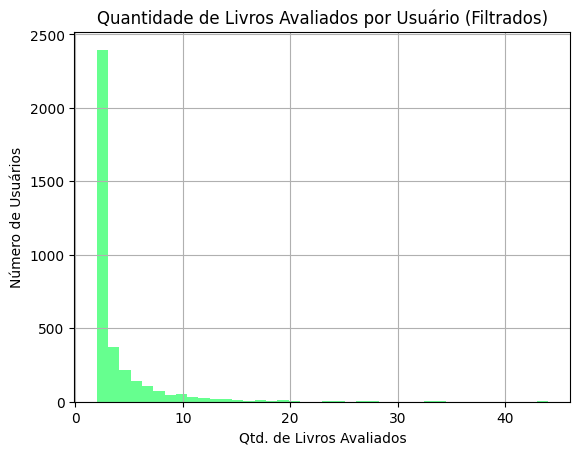

In [14]:
# qtd de livros livros avaliados depois do filtro
books_per_user_filtered = filtered_merged.groupby('user_id')['isbn'].count()
plt.figure()
books_per_user_filtered.hist(bins=40, color=cores['verde'])
plt.title('Quantidade de Livros Avaliados por Usuário (Filtrados)')
plt.xlabel('Qtd. de Livros Avaliados')
plt.ylabel('Número de Usuários')
plt.show()


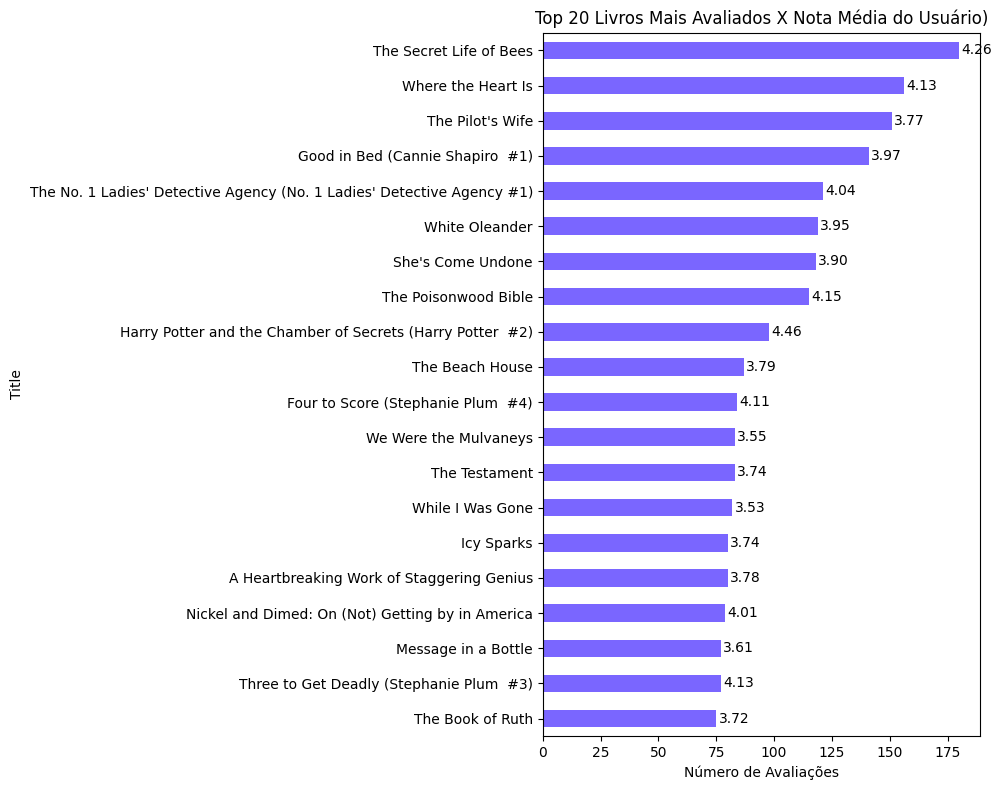

In [15]:
# livros mais populares (mais avaliados)
top_books_counts = filtered_merged['Title'].value_counts().head(20)

# média de ntoa dos livros mais bem avaliados e mantem a ordem
top_books_ratings = filtered_merged[filtered_merged['Title'].isin(top_books_counts.index)].groupby('Title')['user_rating'].mean()
top_books_ratings = top_books_ratings.reindex(top_books_counts.index)

plt.figure(figsize=(10, 8))
ax = top_books_counts.plot(kind='barh', color=cores['roxo'])
plt.title('Top 20 Livros Mais Avaliados X Nota Média do Usuário)')
plt.xlabel('Número de Avaliações')
plt.gca().invert_yaxis()

# exibe a nota media tbm
for i, v in enumerate(top_books_counts):
    avg_rating = top_books_ratings.iloc[i]
    ax.text(v + 1, i, f'{avg_rating:.2f}', va='center')

plt.tight_layout()
plt.show()

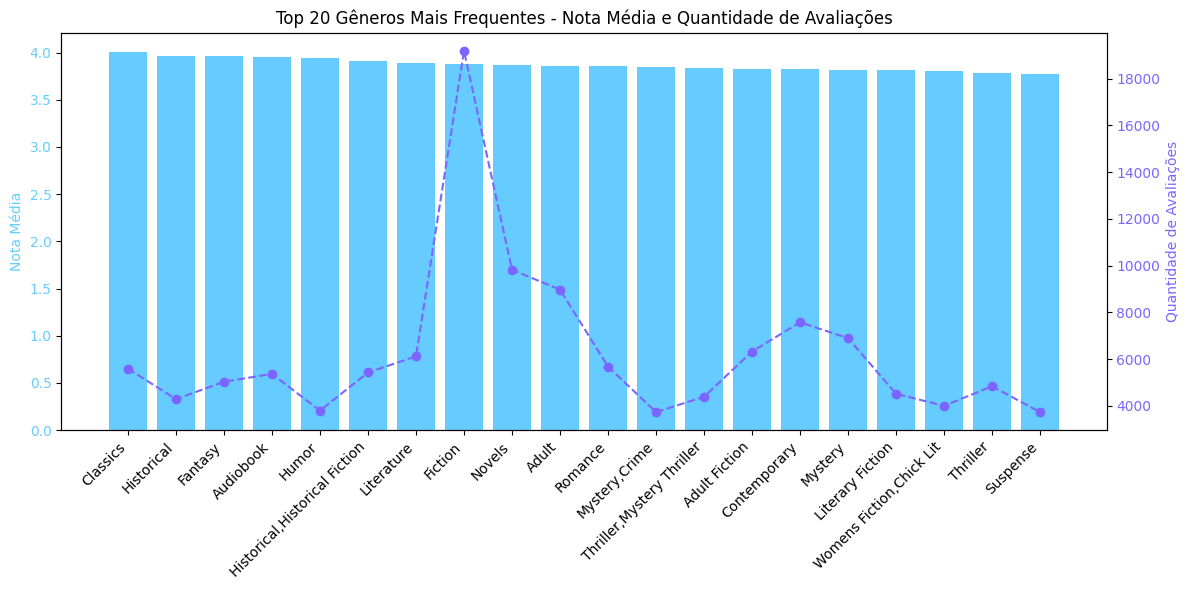

In [16]:
from collections import Counter
import itertools # biblioteca necessária neste caso para desempacotar listas

# lista com todos os generos
generos_expandidos = list(itertools.chain(*merged['genres'].tolist()))

# conto o mais frequente
genre_counts = pd.Series(Counter(generos_expandidos)).sort_values(ascending=False)

# seleciono os 20 mais frequentes
top_genres = genre_counts.head(20).index

# separo 1 linha por gênero
books_genres = merged.explode('genres')

# pegop apenas os gêneros do top 20
top_genres_data = books_genres[books_genres['genres'].isin(top_genres)]

# agrupo para calcular nota média e quantidade
genre_stats = top_genres_data.groupby('genres')['user_rating'].agg(['mean', 'count'])
genre_stats = genre_stats.sort_values(by='mean', ascending=False)


fig, ax1 = plt.subplots(figsize=(12, 6))

# nota média
ax1.bar(genre_stats.index, genre_stats['mean'], color=cores['azul'])
ax1.set_title('Top 20 Gêneros Mais Frequentes - Nota Média e Quantidade de Avaliações')
ax1.set_ylabel('Nota Média', color=cores['azul'])
ax1.tick_params(axis='y', labelcolor=cores['azul'])
ax1.set_xticks(range(len(genre_stats.index)))
ax1.set_xticklabels(genre_stats.index, rotation=45, ha='right')

# quantidade de avaliações
ax2 = ax1.twinx()
ax2.plot(range(len(genre_stats.index)), genre_stats['count'], color=cores['roxo'], marker='o', linestyle='dashed')
ax2.set_ylabel('Quantidade de Avaliações', color=cores['roxo'])
ax2.tick_params(axis='y', labelcolor=cores['roxo'])

plt.tight_layout()
plt.show()


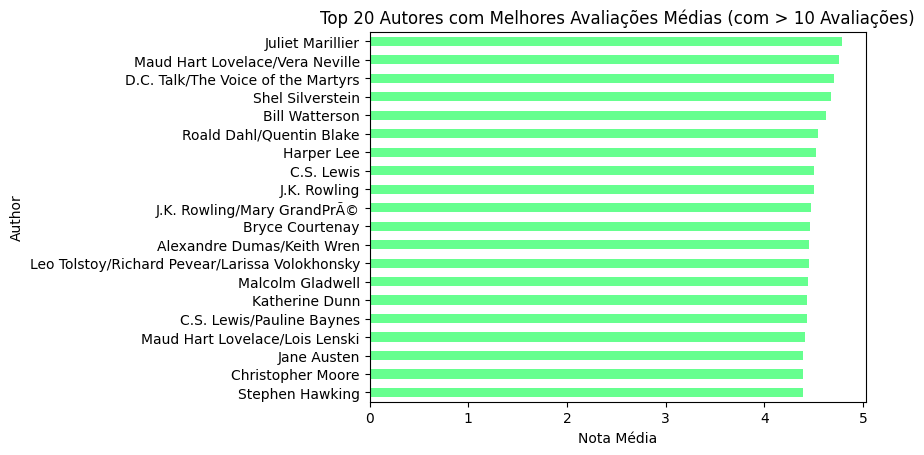

In [17]:
# avaliação média por autor (autores com >10 avs) top 20

# n de avaliações
author_counts = merged['Author'].value_counts()

# > 10 avaliações
authors_with_enough_ratings = author_counts[author_counts > 10].index
filtered_author_data = merged[merged['Author'].isin(authors_with_enough_ratings)]

# média
author_ratings = filtered_author_data.groupby('Author')['user_rating'].mean().sort_values(ascending=False).head(20)

plt.figure()
author_ratings.plot(kind='barh', color=cores['verde'])
plt.title('Top 20 Autores com Melhores Avaliações Médias (com > 10 Avaliações)')
plt.xlabel('Nota Média')
plt.gca().invert_yaxis()
plt.show()


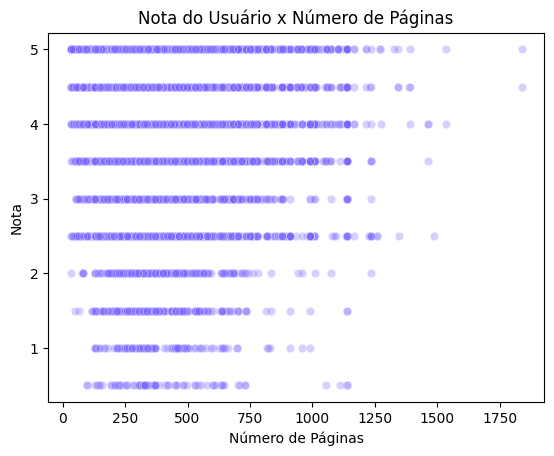

In [18]:
# correlação entre número de páginas e avaliação
plt.figure()
sns.scatterplot(data=merged, x='num_pages', y='user_rating', alpha=0.3, color=cores['roxo'])
plt.title('Nota do Usuário x Número de Páginas')
plt.xlabel('Número de Páginas')
plt.ylabel('Nota')
plt.show()

A visualização deste indicador não está favorável devido ao alto numero de pavaridade de paginas e muita densidade nas faixas de nota, será necessário fazer mais um tratamento neste sentido quanto ao numero de paginas a ser apresentado

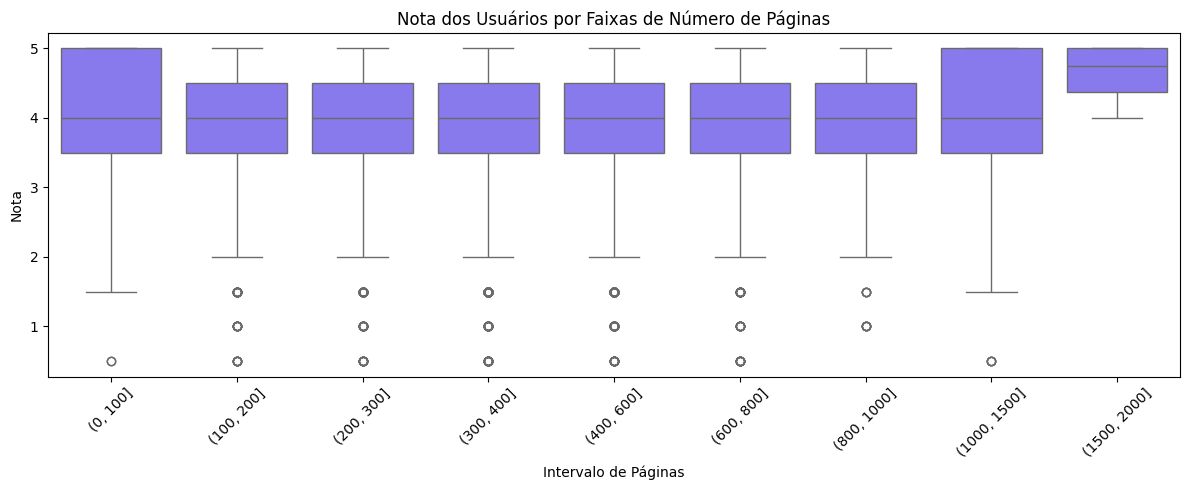

In [19]:
# depois exibo em um boxplot
plt.figure(figsize=(12, 5))
sns.boxplot(x='faixa_paginas', y='user_rating', data=merged, color=cores['roxo'])
plt.title('Nota dos Usuários por Faixas de Número de Páginas')
plt.xlabel('Intervalo de Páginas')
plt.ylabel('Nota')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


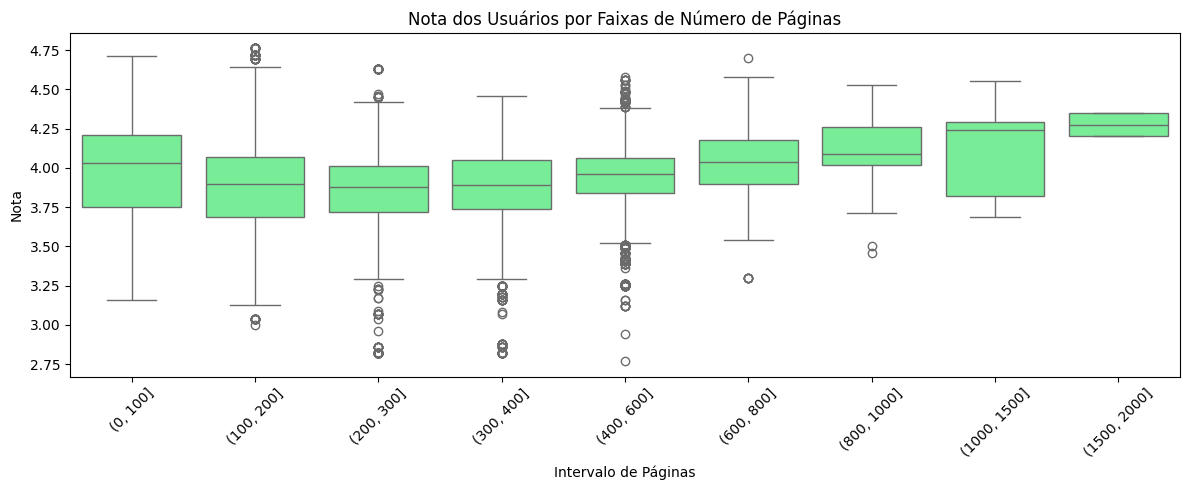

In [20]:
# exibo em um boxplot agora a avaliação de faixa de páginas com base no average_rating
plt.figure(figsize=(12, 5))
sns.boxplot(x='faixa_paginas', y='average_rating', data=merged, color=cores['verde'])
plt.title('Nota dos Usuários por Faixas de Número de Páginas')
plt.xlabel('Intervalo de Páginas')
plt.ylabel('Nota')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# avaliando correlaçao de Pearson e Spearman para identificar se há correlação entre o numero de paginas e avaliação do usuário
pearson_corr = merged['num_pages'].corr(merged['user_rating'], method='pearson')
spearman_corr = merged['num_pages'].corr(merged['user_rating'], method='spearman')

print(f"Correlação de Pearson [user_rating] (linear): {pearson_corr:.3f}")
print(f"Correlação de Spearman [user_rating] (monótona): {spearman_corr:.3f}")


pearson_corr = merged['num_pages'].corr(merged['average_rating'], method='pearson')
spearman_corr = merged['num_pages'].corr(merged['average_rating'], method='spearman')

print(f"Correlação de Pearson [average_rating] (linear): {pearson_corr:.3f}")
print(f"Correlação de Spearman [average_rating] (monótona): {spearman_corr:.3f}")


Correlação de Pearson [user_rating] (linear): 0.004
Correlação de Spearman [user_rating] (monótona): -0.004
Correlação de Pearson [average_rating] (linear): 0.220
Correlação de Spearman [average_rating] (monótona): 0.192


Percebe-se que na base de avaliações dos usuários, a correlação entre o número de páginas e a nota final do livro é pouco significativa, mas na amostragem geral, este fator possui maior impacto, como pode ser constatado tbm no boxplot.

Presupõe-se que, em geral, usuários estarão mais propensos a dar uma nota maior para os livros caso ele tenha um número maior de páginas, provavelmente por conta do fator esforço-recompensa.

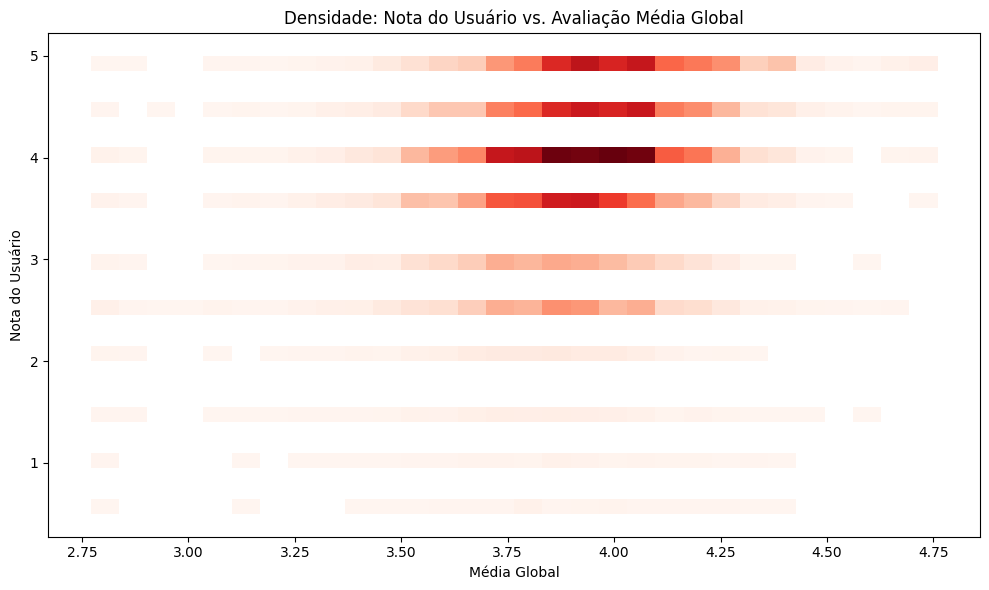

In [ ]:
# correlação entre avaliação média do livro e nota do usuário
plt.figure(figsize=(10, 6))
sns.histplot(data=merged, x='average_rating', y='user_rating', bins=30, cmap='Reds')
plt.title('Densidade: Nota do Usuário vs. Avaliação Média Global')
plt.xlabel('Média Global')
plt.ylabel('Nota do Usuário')
plt.tight_layout()
plt.show()


Nota-se que existe uma correlação nas notas dos usuários x notas gerais somente entre 3.75 e 5

# Features preditivas

Como existe uma evidente correlação entre o autor, o numero de paginas, e o genero para a nota do usuario, os pesos das variavéis será distribuido nesta ordem:


1.   Autor
2.   Páginas
3.   Genero
4.   Média de notas global



In [22]:
def prever_preferencia(user_id, isbn, df):
    # Verifica se o usuário já leu o livro
    leitura = df[(df['user_id'] == user_id) & (df['isbn'] == isbn)]
    if not leitura.empty:
        titulo = leitura.iloc[0]['Title']
        nota = leitura.iloc[0]['user_rating']
        return f"O usuário já leu o livro '{titulo}' e deu a nota {nota}."

    # Obtém dados do livro consultado
    livro_consulta = df[df['isbn'] == isbn]
    if livro_consulta.empty:
        return "ISBN não encontrado na base."

    titulo = livro_consulta.iloc[0]['Title']
    autor = livro_consulta.iloc[0]['Author']
    faixa_paginas = livro_consulta.iloc[0]['faixa_paginas']
    generos_livro = set(livro_consulta.iloc[0]['genres'])
    media_geral = livro_consulta.iloc[0]['average_rating']

    # Avaliações do mesmo autor
    df_autor = df[(df['user_id'] == user_id) & (df['Author'] == autor)]
    notas_autor = df_autor['user_rating']
    qtd_autor = len(notas_autor)
    nota_media_autor = notas_autor.mean() if not notas_autor.empty else None

    # Avaliações com generos semelhantes
    def tem_genero_comum(generos_usuario):
        return not generos_livro.isdisjoint(generos_usuario)

    df_genero = df[(df['user_id'] == user_id) & df['genres'].apply(tem_genero_comum)]
    notas_genero = df_genero['user_rating']
    qtd_genero = len(notas_genero)
    nota_media_genero = notas_genero.mean() if not notas_genero.empty else None

    # Avaliações com mesma faixa de páginas
    df_paginas = df[(df['user_id'] == user_id) & (df['faixa_paginas'] == faixa_paginas)]
    notas_paginas = df_paginas['user_rating']
    qtd_paginas = len(notas_paginas)
    nota_media_paginas = notas_paginas.mean() if not notas_paginas.empty else None

    # Combinação ponderada: pesos definidos conforme relevância
    pesos = {'autor': 0.5, 'genero': 0.2, 'paginas': 0.25, 'media_geral': 0.05}
    soma_pesos = 0
    score = 0

    if nota_media_autor:
        score += pesos['autor'] * nota_media_autor
        soma_pesos += pesos['autor']
    if nota_media_genero:
        score += pesos['genero'] * nota_media_genero
        soma_pesos += pesos['genero']
    if nota_media_paginas:
        score += pesos['paginas'] * nota_media_paginas
        soma_pesos += pesos['paginas']

    score += pesos['media_geral'] * media_geral
    soma_pesos += pesos['media_geral']

    probabilidade = score / soma_pesos

    justificativas = []
    if qtd_genero > 0:
        justificativas.append(f"O usuário já leu {qtd_genero} livro(s) do mesmo gênero e deu uma média de nota {nota_media_genero:.2f}")
    if qtd_paginas > 0:
        justificativas.append(f"O usuário já leu {qtd_paginas} livro(s) com faixa de páginas {faixa_paginas} e deu uma média de nota {nota_media_paginas:.2f}")
    if qtd_autor > 0:
        justificativas.append(f"O usuário já leu {qtd_autor} livro(s) do autor {autor} e deu uma média de nota {nota_media_autor:.2f}")

    justificativas_texto = "\n".join(justificativas) if justificativas else "Não há histórico suficiente do usuário para comparação direta."

    return f"A probabilidade do usuário gostar do livro '{titulo}' é {probabilidade:.2f} (em uma escala de 0 a 5).\n\nJustificativas:\n{justificativas_texto}"


# Função pronta para uso

In [23]:
# Exemplo de uso da função
user_input = 276872
isbn_input = '0439064864'

resultado = prever_preferencia(user_input, isbn_input, merged)
print(resultado)


A probabilidade do usuário gostar do livro 'Harry Potter and the Chamber of Secrets (Harry Potter  #2)' é 3.68 (em uma escala de 0 a 5).

Justificativas:
O usuário já leu 1 livro(s) do mesmo gênero e deu uma média de nota 3.50


### Livros para teste da função

In [24]:
# quantas vezes cada livro foi avaliado
top_livros = merged['isbn'].value_counts().head(20)

# livros mais lidos
display(top_livros)


,count
isbn,
0142001740,307
0446672211,295
0316601950,272
0743418174,236
0060930535,218
0671021001,217
1400034779,183
0316284955,171
0440234743,169


In [25]:
# avaliações
top_usuarios = merged['user_id'].value_counts().head(20)

# usuários mais ativos
display(top_usuarios)

,count
user_id,
11676,293
189835,78
76499,77
98391,62
23902,52
95359,44
16795,43
257204,42
171118,35
